# Extended Kalman Filter
By: Edwin Hartnell

## Acknowledgements

Based upon the [FilterPy library](http://github.com/rlabbe/filterpy) and supporting book [Kalman and Bayesian Filters in Python](https://github.com/rlabbe/Kalman-and-Bayesian-Filters-in-Python) by Roger R Labbe Jr. The example below was adapted from the [Tracking an Airplane](https://github.com/rlabbe/Kalman-and-Bayesian-Filters-in-Python/blob/master/11-Extended-Kalman-Filters.ipynb) example.

## The Why

Kalman Filters work great so long as the world being modeled can be represented as a linear problem, and everything within the model remains Gaussian. But the real-world is non-linear, and the original Kalman Filter needs to be extended to handle this non-linearity.

## 1-Dimensional World

Moving through a 1-dimensional world can be modeled as a linear problem. In the 1-dimensional model below, the vehicle (represented by the triangle icon) encounters landmarks (represented by the flags) as it moves along a straight path. The distance between the vehicle and each landmark is proportional to the starting point and velocity of the vehicle.

![One Dimensional Localization](images/one-dimensional-localization-004.png)

## 2-Dimensional World

But in the 2-dimensional world, such a model is impractical. For starters, the vehicle would be required to collide with every landmark it encountered.

![Two Dimensional Localization](images/robot-car-005.png)

## Robot Car Experiment

Instead, it would be great if we could identify a landmark as the vehicle drove past it. And it would be great if we didn't need to calculate the straight-line distance with LIDAR, but could instead use a smart camera to track the angle of the landmark. In such an experiment, three different sensors on-board a model robot car kit could be used:

1. Infrared line follower probes underneath the car to follow a pre-defined path
2. Tilt-pan camera to identify and track the angle of a landmark
3. Ultrasonic sensor to prevent collision with objects along the track (optional)

Starting from 4 meters back from the origin, the car would use a pre-marked path to drive parallel to the wall at a constant distance of 1 meter and constant velocity of 0.01 m/s.

Along the way, the tilt-pan camera would automatically track a landmark placed along the wall (say a red ball). The pan angle of the camera (theta $\theta$) would be fed to an Extended Kalman Filter (EKF). The EKF would then use this measurement to refine its belief of the vehicle's state location, made up of three state variables:

- x-location
- x-velocity
- y-location

![Localization Experiment](images/localization-experiment-002.png)

## The Code

In [1]:
from __future__ import (absolute_import, division, print_function, unicode_literals)

import matplotlib.pyplot as plt
import math
import numpy as np
from filterpy.kalman import ExtendedKalmanFilter
from numpy import array, eye, asarray
from numpy.random import randn

from filterpy.common import Saver
from filterpy.examples import RadarSim
from pytest import approx
from scipy.spatial.distance import mahalanobis as scipy_mahalanobis

ModuleNotFoundError: No module named 'matplotlib'

## Angle Simulator

The Angle Simulator contains a precise but hidden view of the world. It tracks the exact position of the car and will move the car along the straight path at a constant speed each time the routine `step_get_angle()` is called. The Angle Simulator is capable of injecting some random Gaussian drift into the velocity and y-position, and will add process error to the measured angle it returns to the Extended Kalman Filter.

In [2]:
class AngleSimulator(object):
    """
    Simulates the angle signal returned from an AI camera tracking a landmark.
    Only the Horizontal Position (x) is changing with Angle (theta) depending upon (x,y) position.
    Assumes the Vertical Position (y) and Velocity are constant, although
    Vertical Postition and Velocity experiences minor drift variation with each call.
    Assumes random process noise is also added to the measured angle.
    """

    def __init__(self, dt=1.0, x_position=-10.0, x_velocity=0.1, y_position=1.0):
        """
        We want to track the position of the car assuming a constant velocity and
        fixed position to the wall. And we want to measure the angle between
        the car and a stationary landmark placed against the wall.
        Our state variables are: x_position, x_velocity, and y_position.
        """
        self.dt = dt # seconds
        self.x_position = x_position # meters along track
        self.x_velocity = x_velocity # meters/second along track (constant other than drift)
        self.y_position = y_position # meters from wall (constant other than drift)

    def get_actual_state_measurement(self):
        """
        Return the actual state and measurement in an array.
        """
        return [self.x_position, self.x_velocity, self.y_position, calculate_measurement( self.x_position, self.y_position )]

    def step_get_angle(self, position_process_error=0.1):
        """
        First step the actual position by a dt delta time increment.
        Then return the angle to the object between the fixed y_position and the changing x_position.
        Call this step function once per dt time for each new measurement.
        """
        VELOCITY_DRIFT = 0.01 # meters/second
        POSITION_DRIFT = 0.1 # meters from wall
        x_velocity = self.x_velocity + VELOCITY_DRIFT* randn() # meters/second along track (constant other than drift)
        y_position = self.y_position + POSITION_DRIFT * randn() # meters from wall (constant other than drift)
        self.x_position += x_velocity * self.dt # actual x_position meters from origin
        measurement_noise = position_process_error * randn() # meters along track
        measured_x_position = self.x_position + measurement_noise # measured x_position meters from origin
        measured_angle = calculate_measurement( measured_x_position, y_position ) # measured angle in radians
        return measured_angle

## Calculate Measurement

The same `calculate_measurement()` is used throughout the simulation. The routine calculates the `arc-tan` of the angle theta $\theta$ as a ratio of the x-position and y-position. But undesirable discontinuities are introduced into the simulation when the x-location of the car passes the origin. When this happens, the returned theta suddenly switches from a large positive value to a large negative value. This, in turn, causes the uncertainty of the EKF to jump. To avoid this, the `arc-tan` of `x/y` is used instead of `y/x`.

In [3]:
def calculate_measurement(x_position, y_position):
    measurement = math.atan( x_position / y_position ) # Avoids the angle rolling over when the x_position passes the origin
    return measurement

## Linearizing the Kalman Filter

The Extended Kalman Filter (EKF) is designed to handle non-linear models. It does this by _linearizing_ the Measurement Function `H`. For the original linear Kalman Filter, `H` is a constant that is calculated once before running the filter. For the EKF, `H` is updated each time the estimated state variables change. In our case, this is when `step_get_angle()` is called. `H` is linearized by evaluating the partial derivative of the measurement `calculate_measurement()` with respect to each state variable. The result is the Jacobian matrix of the measurement function.

In [4]:
def hx(x):
    """
    The measurement function h(x) takes the estimate of the prior state variables
    and returns the desired angle measurement that would correspond to that state.
    Note that the size of the opposite angle from the car is returned as a measurement.
    This avoids the angle measurement suddenly rolling over from pi/2 to -pi/2
    which causes the uncertainty variance to suddenly sky-rocket.
    """
    x_position = x[0]
    x_velocity = x[1]
    y_position = x[2]
    measured_angle = calculate_measurement( x_position, y_position ) # measured angle in radians
    return measured_angle

def H_of(x):
    """
    The relationship between the angle measurement and the state variables is non-linear.
    This relationship can linearized by evaluating its partial derivative at x_t.
    The partial derivative of a matrix is called the Jacobian of H matrix for state x.
    Each element in the matrix is the partial derivative of the function h(x)
    with respect to each of the state variables.

    H = [dh/dx, dh/dv, dh/dy]
    dh/dx = d( atan(y/x) )/dx = -y/(x**2 + y**2)
    dh/dv = d( atan(y/x) )/dv = 0.0
    dh/dy = d( atan(y/x) )/dy = x/(x**2 + y**2)

    When the size of the opposite angle from the car is returned as a measurement
    the following Jacobian matrix is returned. See h(x) for explanation above.

    H = [dh/dx, dh/dv, dh/dy]
    dh/dx = d( atan(x/y) )/dx = y/(x**2 + y**2)
    dh/dv = d( atan(x/y) )/dv = 0.0
    dh/dy = d( atan(x/y) )/dy = -x/(x**2 + y**2)

    For the Linear Kalman Filter, H is a constant that is calculated once before running the filter.
    For the Extended Kalman Filter, H is updated each time the estimated state variables change.
    """
    x_position = x[0]
    x_velocity = x[1]
    y_position = x[2]
    # jacobian = [[ -y_position / (x_position**2 + y_position**2), 0.0, x_position / (x_position**2 + y_position**2) ]] # Based upon the original theta measurement
    jacobian = [[ y_position / (x_position**2 + y_position**2), 0.0, -x_position / (x_position**2 + y_position**2) ]] # Avoids the angle rolling over when the x_position passes the origin
    return array(jacobian)

## Running Model

Finally, a model of the experiment is developed. This comprises a 3-dimensional state variable, along with a Measurement Uncertainty Noise Matrix `R` and a Process Uncertainty Noise Matrix `Q`, with the State Covariance Matrix `P` initialized with values proportional to the dimensions of the modeled world.

### Initialization

In [5]:
# Physical constants in the world
dt = 1.0 # seconds size of time step
position_process_error = 0.05 # meters impacting x_position along track

# Initial state variables
x_position = -4.0 # meters along track
x_velocity = 0.01 # meters/second along track (constant other than drift)
y_position = -1.0 # meters from wall (constant other than drift)
INITIAL_GUESS = 0.2 # initialize the filter to be near the true state

# Define the Angle Simulator
angle_simulator = AngleSimulator(dt, x_position, x_velocity, y_position)

# Define the Extended Kalman Filter
rk = ExtendedKalmanFilter(dim_x=3, dim_z=1) # dim_x = size of state variable vector (x,v,y), dim_z = size of measurement vector (angle)
rk.x = array([x_position*(1.0-INITIAL_GUESS), x_velocity*(1.0+INITIAL_GUESS), y_position-INITIAL_GUESS]) # Initialize the state estimate vector

# State transition matrix assuming a Newtonian kinematic system
# x_position' = x_position + x_velocity
# x_velocity' = x_velocity
# y_position' = y_position
rk.F = eye(3) + array ([[0, 1, 0],
                        [0, 0, 0],
                        [0, 0, 0]])*dt

INITIAL_MEASUREMENT_UNCERTAINTY = math.pi / 2.0 # 90-degrees = pi/2 = anywhere within the possible angle
rk.R *= INITIAL_MEASUREMENT_UNCERTAINTY**2 # Measurement uncertainty noise matrix
rk.Q = array([[1, 0, 0],
              [0, 1, 0],
              [0, 0, 0]]) * 0.001 # Process uncertainty noise matrix

INITIAL_COVARIANCE_UNCERTAINTY = abs(x_position) # Anywhere along the track
#rk.P *= INITIAL_COVARIANCE_UNCERTAINTY # Covariance matrix
rk.P = array([[1, 0, 0],
              [0, 1, 0],
              [0, 0, 0]]) * INITIAL_COVARIANCE_UNCERTAINTY # Covariance matrix - no uncertainty about the y_position

### Iteration

In [6]:
# Track the history of the simulation
actual_state_and_measurement_history = []
belief_state_history = []
measured_angle_history = []
covariance_matrix_history = []

actual_state_and_measurement_history.append( angle_simulator.get_actual_state_measurement() )
belief_state_history.append(rk.x)
measured_angle_history.append( calculate_measurement( rk.x[0], rk.x[2] ) )
covariance_matrix_history.append(rk.P)

# Iterate from the beginning of the track but do not go past the origin
for i in range( int(abs(x_position/(dt*x_velocity))) ):
    z = angle_simulator.step_get_angle(position_process_error)
    actual_state_measurement = angle_simulator.get_actual_state_measurement()
    if actual_state_measurement[0] > 0.0:
        break # Do not go past the origin
    actual_state_and_measurement_history.append( actual_state_measurement )
    measured_angle_history.append(z)

    rk.update(asarray([z]), H_of, hx, R=hx(rk.x)*position_process_error)
    covariance_matrix_history.append(rk.P)
    rk.predict()
    belief_state_history.append(rk.x)

    # test mahalanobis
    a = np.zeros(rk.y.shape)
    maha = scipy_mahalanobis(a, rk.y, rk.SI)
    try:
        assert rk.mahalanobis == approx(maha)
    except:
        print(f'At iteration {i+1} of {int(abs(x_position/(dt*x_velocity)))}: rk.mahalanobis != approx(maha)')

actual_state_and_measurement_history = asarray(actual_state_and_measurement_history)
belief_state_history = asarray(belief_state_history)
measured_angle_history = asarray(measured_angle_history)
covariance_matrix_history = asarray(covariance_matrix_history)
p_x_position_variance = covariance_matrix_history[:, 0, 0]
p_x_velocity_variance = covariance_matrix_history[:, 1, 1]
p_y_position_variance = covariance_matrix_history[:, 2, 2]

## Charting Results

The measured angle from the car to the landmark is first plotted as a function of the `dt` time tick. The belief of each state variable is then plotted against its actual value over time. Finally, the x-location of the car is plotted along with the converging uncertainty of its variance.

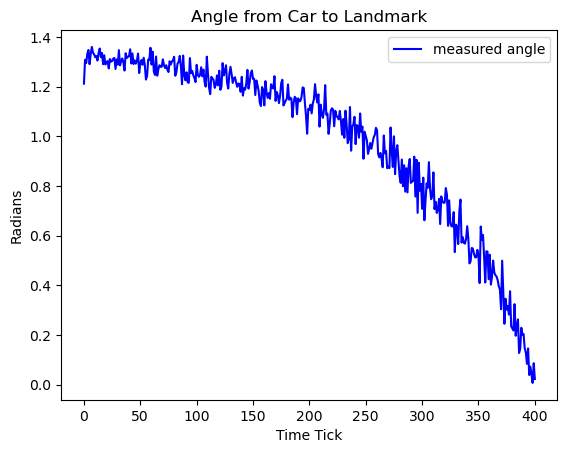

In [7]:
plt.title("Angle from Car to Landmark")
plt.plot(measured_angle_history, label='measured angle', color='blue')
plt.xlabel('Time Tick')
plt.ylabel('Radians')
plt.legend()

Text(0.5, 0, 'iteration')

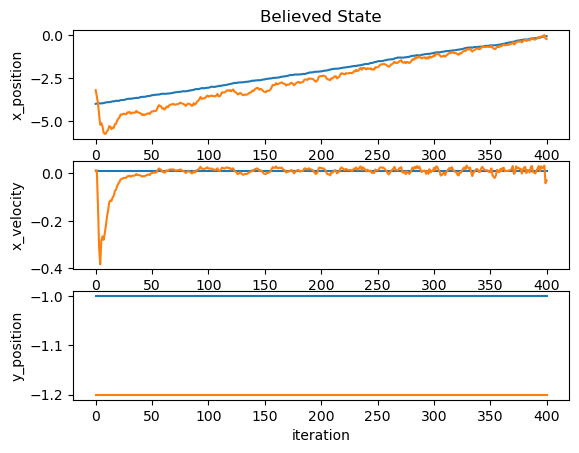

In [8]:
plt.subplot(311)
plt.title("Believed State")
plt.plot(actual_state_and_measurement_history[:, 0])
plt.plot(belief_state_history[:, 0])
plt.ylabel('x_position')

plt.subplot(312)
plt.plot(actual_state_and_measurement_history[:, 1])
plt.plot(belief_state_history[:, 1])
plt.ylabel('x_velocity')

plt.subplot(313)
plt.plot(actual_state_and_measurement_history[:, 2])
plt.plot(belief_state_history[:,2])
plt.ylabel('y_position')
plt.xlabel('iteration')

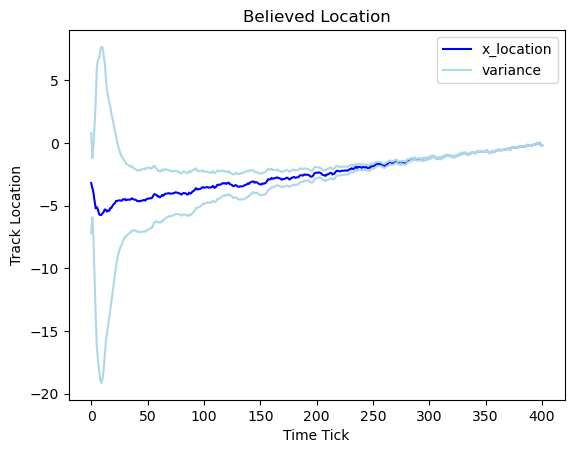

In [9]:
plt.title("Believed Location")
plt.plot(belief_state_history[:, 0], label='x_location', color='blue')
plt.plot(belief_state_history[:, 0] + p_x_position_variance, label='variance', color='lightblue')
plt.plot(belief_state_history[:, 0] - p_x_position_variance, label='', color='lightblue')
plt.xlabel('Time Tick')
plt.ylabel('Track Location')
plt.legend()